In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
class SkipGramData(Dataset):
    def __init__(self, corpus, window_size=2):
        super().__init__()
        self.corpus = corpus
        self.window = window_size
        self.data = []
        self.vocab = list(set([token.lower() for sentence in self.corpus for token in sentence.split()]))
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.data = self.gen_dataset()

    def gen_dataset(self):
        data  = []
        for sentence in self.corpus:
            text = sentence.lower().split()
            for center_idx, center_word in enumerate(text):
                for offset in range(-self.window, self.window + 1):
                    context_idx = center_idx + offset
                    if context_idx < 0 or context_idx >= len(text) or context_idx == center_idx: continue
                    context_word = text[context_idx]
                    data.append((self.word2idx[center_word], self.word2idx[context_word]))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [3]:
class skipGram(nn.Module):
    def __init__(self, vocab_size, embeddings_size):
        super().__init__()
        self.embed_layer = nn.Linear(vocab_size, embeddings_size, bias= False)
        self.output_layer = nn.Linear(embeddings_size, vocab_size, bias = False)

    def forward(self, x):
        x = self.embed_layer(x)
        x = self.output_layer(x)
        return x

In [4]:
def train_skipgram(model, loss_function, optimizer, data_loader, epochs=5):
    for epoch in range(epochs): 
        total_loss = 0
        for center, context in data_loader:
            center_vector = torch.zeros(len(data_loader.dataset.vocab))
            center_vector[center] = 1.0
            center_vector = center_vector.unsqueeze(0)
            
            scores = model(center_vector)

            #context_vector = torch.zeros(len(data_loader.dataset.vocab))
            #context_vector[context] = 1.0
            #print("scores.shape", scores.shape)
            #print("context.shape", context.shape)
            loss = loss_function(scores, torch.tensor([context]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch: {epoch+1}, Loss: {total_loss/len(data_loader)}")



In [5]:
sentences = [
    "La inteligencia artificial esta chida",
    "El procesamiento de lenguaje natural es una rama del aprendizaje profundo",
    "Me encanta estudiar inteligencia artificial",
    "Las peliculas de inteligencia artificial me encantan",
    "El aprendizaje profundo es una subcategoria de la inteligencia artificial",
    "Los embeddings de palabras capturan semantica",
    "PyTorch es una herramienta para aprendizaje profundo e inteligencia artificial"
]

In [6]:
dataset = SkipGramData(sentences, window_size=2)
data_loader = DataLoader(dataset, batch_size = 1, shuffle=True)

In [7]:
learning_rate = 0.00001
loss_function = nn.CrossEntropyLoss()
model = skipGram(vocab_size = len(dataset.vocab), embeddings_size=300)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [8]:
train_skipgram(model, loss_function, optimizer, data_loader, epochs=2000)

Epoch: 1, Loss: 3.458735290615038
Epoch: 2, Loss: 3.456405754747062
Epoch: 3, Loss: 3.454150623288648
Epoch: 4, Loss: 3.4518670501380133
Epoch: 5, Loss: 3.4496233888056085
Epoch: 6, Loss: 3.4472949970727678
Epoch: 7, Loss: 3.445025549537834
Epoch: 8, Loss: 3.4427198884130896
Epoch: 9, Loss: 3.440435805539975
Epoch: 10, Loss: 3.438151206093273
Epoch: 11, Loss: 3.4358415987299775
Epoch: 12, Loss: 3.4335515526519425
Epoch: 13, Loss: 3.431239483000218
Epoch: 14, Loss: 3.4289541819999956
Epoch: 15, Loss: 3.426644380065216
Epoch: 16, Loss: 3.4243675360734436
Epoch: 17, Loss: 3.422074813952391
Epoch: 18, Loss: 3.4197732676034684
Epoch: 19, Loss: 3.4175034802535484
Epoch: 20, Loss: 3.415225346883138
Epoch: 21, Loss: 3.4129087979766144
Epoch: 22, Loss: 3.4106205989574563
Epoch: 23, Loss: 3.4083095556017997
Epoch: 24, Loss: 3.4060096562593833
Epoch: 25, Loss: 3.403723112468062
Epoch: 26, Loss: 3.401425487693699
Epoch: 27, Loss: 3.3991296113222496
Epoch: 28, Loss: 3.396864755400296
Epoch: 29, Los

In [12]:
def plot_embeddings(embeddings, word2idx):
    num_samples = len(word2idx)
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 10))
    for word, idx in word2idx.items():
        plt.scatter(vectors[idx, 0], vectors[idx,1])
        plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embeddings Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

/tmp/ipykernel_106072/1766923198.py:8: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), textcoords='offset points', ha='right', va='bottom')


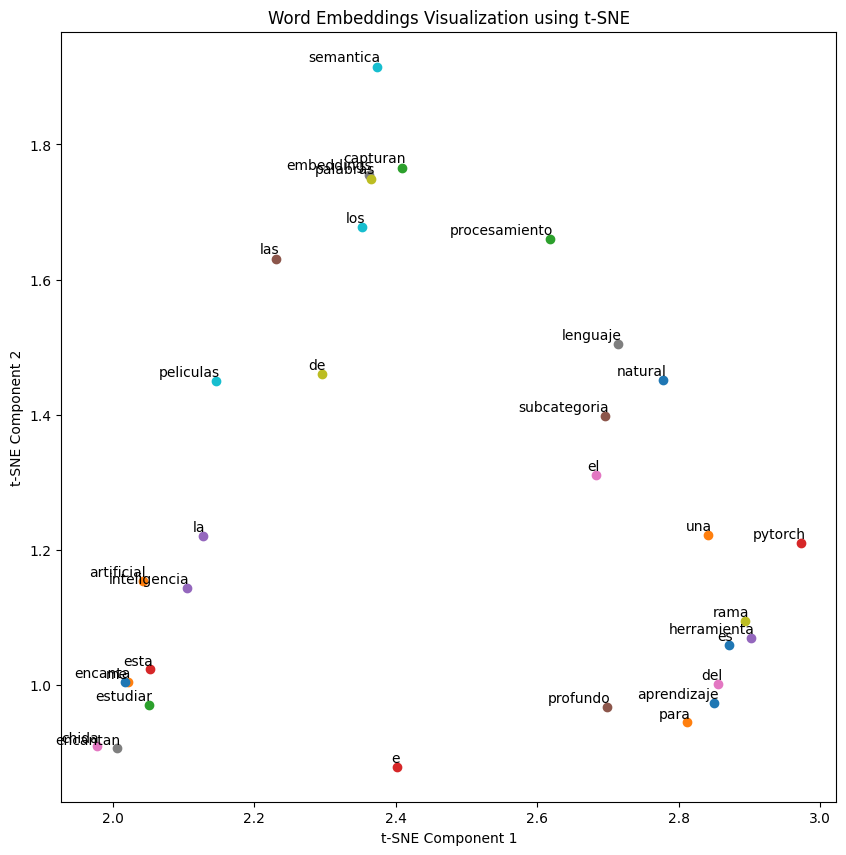

In [13]:
embeddings = model.embed_layer.weight.detach().numpy().T
plot_embeddings(embeddings, dataset.word2idx)

In [11]:
print("embeddings.shape", embeddings.shape)

embeddings.shape (32, 300)
